In [2]:
#导入必要依赖库
import torch.optim
import  torchvision
from torch.nn import Linear, Flatten, MaxPool2d, Conv2d
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch import  nn
from torch.utils.tensorboard import SummaryWriter
import os
import pandas as pd
from PIL import Image
import torch.nn.init as init
import matplotlib.pyplot as plt

In [3]:
# 文件夹准备
# 拼接模型保存路径
folder_path = "../models/GoogleNet"

Train_data_path = '../RAF/images/train'
test_data_path = "../RAF/images/test"

if not os.path.exists(folder_path):
    os.makedirs(folder_path)  

In [4]:
# 查看图片模式和向量大小，方便数据初始化和确认通道数
img = Image.open("../RAF/images/all/0/test_0002_aligned.jpg")
tensor = torchvision.transforms.ToTensor()(img)
print("Tensor 形状：", tensor.shape) 
print("图像模式：", img.mode)

Tensor 形状： torch.Size([3, 100, 100])
图像模式： RGB


In [13]:
###准备数据集和测试集
###Tensor 形状： torch.Size([3, 100, 100]) 图像模式： RGB
transform = torchvision.transforms.Compose([
     torchvision.transforms.Resize((224,224)),          #统一尺寸
    torchvision.transforms.ToTensor(),                   # 转换为 [C, H, W] 的张量，范围 [0, 1]
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225])  
])
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),       # 水平翻转
    torchvision.transforms.RandomRotation(10),                # 旋转 ±10°
    torchvision.transforms.ColorJitter(brightness=0.1, contrast=0.1),  # 颜色抖动
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_data = torchvision.datasets.ImageFolder(root=Train_data_path, transform=train_transform)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True,drop_last=True)

test_data = torchvision.datasets.ImageFolder(root=test_data_path, transform=transform)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False,drop_last=True)

print("类别标签顺序：", train_data.classes)

类别标签顺序： ['0', '1', '2', '3', '4', '5', '6']


In [14]:
model = torchvision.models.googlenet(pretrained=True, aux_logits=True)

model.fc = nn.Linear(model.fc.in_features, 7)  
model.aux1.fc2 = nn.Linear(model.aux1.fc2.in_features, 7)
model.aux2.fc2 = nn.Linear(model.aux2.fc2.in_features, 7)

model.cuda()

loss_function = nn.CrossEntropyLoss()
loss_function=loss_function.cuda()

optimizer = torch.optim.AdamW(model.parameters(), 
                              lr=1e-3, 
                              weight_decay=1e-4)


epoch = 25
accuracy = 0
best_acc = 0

accuracies=[]
losses = []

train_data_len = len(train_data)
test_data_len = len(test_data)
print("训练集的长度为{}".format(train_data_len))
print("测试集的长度为{}".format(test_data_len))

训练集的长度为12271
测试集的长度为3068


In [37]:
total_train_step = 0
torch.cuda.empty_cache()## 训练之前清理显存避免显存爆炸

for i in range(epoch):
    print("---------第{}轮训练开始---------".format(i+1))
    model.train()
    for data in train_loader:
        
        img,target = data
        img= img.cuda()
        target = target.cuda()

        outputs, aux1, aux2 = model(img)
        

        loss_main = loss_function(outputs, target)
        loss_aux1 = loss_function(aux1, target)
        loss_aux2 = loss_function(aux2, target)

        loss = loss_main + 0.3 * loss_aux1 + 0.3 * loss_aux2


       # loss=loss_function(outputs,target)
        optimizer.zero_grad()

        loss.backward()
        optimizer.step()
        
        total_train_step+=1
        if total_train_step % 20==0:
            print("训练次数{}，Loss：{}".format(total_train_step,loss.item()))

    #测试步骤
    total_test_loss = 0
    total_accuracy = 0
    with torch.no_grad():
        model.eval()
        for data in test_loader :
            img,target = data
            img = img.cuda()
            target = target.cuda()
            
            print(img.shape)
            
            output = model(img)
            
            print(output.shape)

            loss_main = loss_function(output, target)

            total_test_loss+=loss.item()

            accuracy = (output.argmax(1) == target ).sum().item()
            total_accuracy += accuracy
    print("正确率{}".format(total_accuracy/test_data_len))
    accuracies.append(total_accuracy/test_data_len)
    print("整体测试集上的Loss{}".format(total_test_loss))
    losses.append(total_test_loss)
    torch.save(model, os.path.join(folder_path, "module_{}.pth".format(i)))

---------第1轮训练开始---------
训练次数20，Loss：0.7613600492477417
训练次数40，Loss：0.8940524458885193
训练次数60，Loss：0.8894891142845154
训练次数80，Loss：0.884486734867096
torch.Size([128, 3, 224, 224])
torch.Size([128, 7])
torch.Size([128, 3, 224, 224])
torch.Size([128, 7])
torch.Size([128, 3, 224, 224])
torch.Size([128, 7])
torch.Size([128, 3, 224, 224])
torch.Size([128, 7])
torch.Size([128, 3, 224, 224])
torch.Size([128, 7])
torch.Size([128, 3, 224, 224])
torch.Size([128, 7])
torch.Size([128, 3, 224, 224])
torch.Size([128, 7])
torch.Size([128, 3, 224, 224])
torch.Size([128, 7])
torch.Size([128, 3, 224, 224])
torch.Size([128, 7])
torch.Size([128, 3, 224, 224])
torch.Size([128, 7])
torch.Size([128, 3, 224, 224])
torch.Size([128, 7])
torch.Size([128, 3, 224, 224])
torch.Size([128, 7])
torch.Size([128, 3, 224, 224])
torch.Size([128, 7])
torch.Size([128, 3, 224, 224])
torch.Size([128, 7])
torch.Size([128, 3, 224, 224])
torch.Size([128, 7])
torch.Size([128, 3, 224, 224])
torch.Size([128, 7])
torch.Size([128, 3,

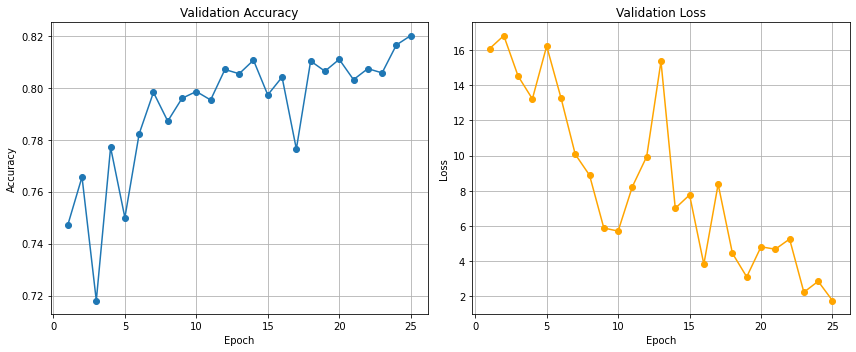

In [3]:
import matplotlib.pyplot as plt

# Epoch数
epochs = list(range(1, 26))

# 验证准确率
accuracy = [
    0.7470664928292047, 0.765645371577575, 0.7180573663624511, 0.7770534550195567,
    0.75, 0.7822685788787483, 0.7982398956975228, 0.7871577574967406,
    0.7959582790091264, 0.7985658409387223, 0.7953063885267275, 0.8070404172099087,
    0.8054106910039114, 0.810625814863103, 0.7972620599739244, 0.8041069100391134,
    0.7764015645371578, 0.8102998696219035, 0.8063885267275098, 0.8109517601043025,
    0.803129074315515, 0.8073663624511083, 0.8057366362451108, 0.8164928292046936,
    0.8200782268578879
]

# 测试集损失
loss = [
    16.071003675460815, 16.814443707466125, 14.517585277557373, 13.21834808588028,
    16.2192645072937, 13.284789085388184, 10.075396120548248, 8.8843714594841,
    5.886483371257782, 5.709445491433144, 8.240333139896393, 9.943663626909256,
    15.352637529373169, 7.0055950582027435, 7.766433268785477, 3.827239081263542,
    8.373945832252502, 4.449607476592064, 3.109193727374077, 4.817786440253258,
    4.681632429361343, 5.258741021156311, 2.237141728401184, 2.858347252011299,
    1.7639806047081947
]

# 绘图
plt.figure(figsize=(12, 5))

# 准确率图
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, marker='o', label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.grid(True)

# 损失图
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, marker='o', color='orange', label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.grid(True)

plt.tight_layout()
plt.show()
